# Imports

Requirements:
- python 3.6
- numpy
- matplotlib
- seaborn
- pytorch
- torchvision
- tqdm
- joblib

Note: some of the images won't show on github, but they should if you download the notebook locally and use a recent enough version of jupyter.

In [1]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
import multiprocessing
import os.path
import csv
import functools #added for resolve the problem of optimizer parameter's list empty
from meta_module import *
import copy
import joblib
from torchvision import datasets
import torchvision
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")
from pdb import set_trace as bp

In [2]:
USE_CUDA = torch.cuda.is_available()

def w(v):
    if USE_CUDA:
        return v.cuda()
    return v


In [3]:
!mkdir -p _cache
cache = joblib.Memory(location='_cache', verbose=0)

# Intro

This notebook is a reproduction of the paper "Learning to Learn by Gradient Descent by Gradient Descent" (https://arxiv.org/abs/1606.04474). 

In a word, this paper is trying to replace the optimizers normally used for neural networks (eg Adam, RMSprop, SGD etc.) by a recurrent neural network: after all, gradient descent is fundamentally a **sequence** of updates (from the output layer of the neural net back to the input), in between which a **state** must be stored. Thus we can think of an optimizer as a mini-RNN. The idea in this paper is to actually train that RNN instead of using a generic algorithm like Adam/SGD/etc..

## Loss

The loss function described in the paper seems complicated, but in reality it is very simple: all it is saying is that the loss of the optimizer is the sum of the losses of the optimizee as it learns. The paper includes some notion of weighing but gives a weight of 1 to everything, so that it indeed is just the sum.

$$\mathcal{L}(\phi) = \mathbb{E}_f \left[ \sum_{t=1}^T w_t f(\theta_t) \right]$$
where
$$\theta_{t+1} = \theta_t + g_t$$
$$\begin{bmatrix} g_t \\ h_{t+1} \end{bmatrix} = m(\nabla_t, h_t, \phi)$$

The $w_t$ are arbitrary weights for each timestep. If we only set the last $w_t$ to 1 and the rest to 0, we are optimizing for the best **final** result with our optimizee. This seems reasonable, but it makes it much harder to train. Instead we will use $w_t$ = 1 for all $t$. $\nabla_t = \nabla_{\theta} f(\theta_t)$.

$f$ is the *optimizee* function, and $\theta_t$ is its parameters at time $t$.
$m$ is the *optimizer* function, $\phi$ is its parameters. $h_t$ is its state at time $t$. $g_t$ is the update it outputs at time $t$.

The plan is thus to use gradient descent on $\phi$ in order to minimize $\mathcal{L}(\phi)$, which should give us an optimizer that is capable of optimizing $f$ efficiently.

As the paper mention, it is important that the gradients in dashed lines in the figure below are **not** propagated during gradient descent.

![image.png](attachment:image.png)

Basically this is nothing we wouldn't expect: the loss of the optimizer neural net is simply the average training loss of the optimizee as it is trained by the optimizer. The optimizer takes in the gradient of the current coordinate of the optimizee as well as its previous state, and outputs a suggested update that we hope will reduce the optimizee's loss as fast as possible.

## Coordinatewise

Informally speaking, coordinatewise optimization is to optimize each parameter by its own state. Any momentum or energy term used in the optimization is based on each parameter's own history, independent on others. Each parameter's optimization state is not shared across other coordinates.

The precondition assumed in ths paper, is that all parameters share the same weights in the LSTM meta optimizer.

# Implementation

As we perform operations, Pytorch builds the computational graph of the operations we perform. However, there are some variables that we want to detach from the graph at various points, specifically we want to pretend that the gradients are inputs (as specified in the previous image) that come from nowhere, instead of coming from the rest of the computational graph as they really do: this means we want to **detach** the gradients from the graph. Likewise, when every 20 steps we perform backpropagation on the optimizer network, we want the current hidden states and cell states, as well as the parameters of the optimizee to "forget" that they are dependent on previous steps in the graph. For all of this, I created a function called `detach_var` which creates a new Variable from the current variable's data, and makes sure that its gradients are still kept. This is different from the `.detach()` function in Pytorch which does not quite forget the original graph and also does not guarantee that the gradients will be there.

In [4]:
def detach_var(v):
    var = w(Variable(v.data, requires_grad=True))
    var.retain_grad()
    return var



def rsetattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    return setattr(rgetattr(obj, pre) if pre else obj, post, val)

# using wonder's beautiful simplification: https://stackoverflow.com/questions/31174295/getattr-and-setattr-on-nested-objects/31174427?noredirect=1#comment86638618_31174427

def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))

def do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True):
    if should_train:
        opt_net.train()
    else:
        opt_net.eval()
        unroll = 1
    
    target = target_cls(training=should_train)
    optimizee = w(target_to_opt())
    n_params = 0
    for name, p in optimizee.all_named_parameters():
        n_params += int(np.prod(p.size()))
    hidden_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    cell_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    all_losses_ever = []
    if should_train:
        meta_opt.zero_grad()
    all_losses = None
    for iteration in range(1, optim_it + 1):
        loss = optimizee(target)
                    
        if all_losses is None:
            all_losses = loss
        else:
            all_losses += loss
        
        all_losses_ever.append(loss.data.cpu().numpy())
        loss.backward(retain_graph=should_train)

        offset = 0
        result_params = {}
        hidden_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        cell_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        for name, p in optimizee.all_named_parameters():
            cur_sz = int(np.prod(p.size()))
            # We do this so the gradients are disconnected from the graph but we still get
            # gradients from the rest
            gradients = detach_var(p.grad.view(cur_sz, 1))
            updates, new_hidden, new_cell = opt_net(
                gradients,
                [h[offset:offset+cur_sz] for h in hidden_states],
                [c[offset:offset+cur_sz] for c in cell_states]
            )
            for i in range(len(new_hidden)):
                hidden_states2[i][offset:offset+cur_sz] = new_hidden[i]
                cell_states2[i][offset:offset+cur_sz] = new_cell[i]
            result_params[name] = p + updates.view(*p.size()) * out_mul
            result_params[name].retain_grad()
            
            offset += cur_sz
            
        if iteration % unroll == 0:
            if should_train:
                meta_opt.zero_grad()
                all_losses.backward()
                meta_opt.step()
                
            all_losses = None

            optimizee = w(target_to_opt())
            optimizee.load_state_dict(result_params)
            optimizee.zero_grad()
            hidden_states = [detach_var(v) for v in hidden_states2]
            cell_states = [detach_var(v) for v in cell_states2]
            
        else:
            for name, p in optimizee.all_named_parameters():
                rsetattr(optimizee, name, result_params[name])
            assert len(list(optimizee.all_named_parameters()))
            hidden_states = hidden_states2
            cell_states = cell_states2
            
    return all_losses_ever


@cache.cache
def fit_optimizer(target_cls, target_to_opt, preproc=False, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0):
    opt_net = w(Optimizer(preproc=preproc))
    meta_opt = optim.Adam(opt_net.parameters(), lr=lr)
    
    best_net = None
    best_loss = 100000000000000000
    
    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True)
        
        loss = (np.mean([
            np.sum(do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=False))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())
            
    return best_loss, best_net
  


# Experiment repro

## Quadratic functions

These are pretty simple: our optimizer is supposed to find a 10-element vector called $\theta$ that, when multiplied by a 10x10 matrix called $W$, is as close as possible to a 10-element vector called $y$. Both $y$ and $W$ are generated randomly. The error is simply the squared error.

In [5]:
class QuadraticLoss:
    def __init__(self, **kwargs):
        self.W = w(Variable(torch.randn(10, 10)))
        self.y = w(Variable(torch.randn(10)))
        
    def get_loss(self, theta):
        return torch.sum((self.W.matmul(theta) - self.y)**2)
    
class QuadOptimizee(MetaModule):
    def __init__(self, theta=None):
        super().__init__()
        self.register_buffer('theta', to_var(torch.zeros(10).cuda(), requires_grad=True))
        
    def forward(self, target):
        return target.get_loss(self.theta)

    def named_leaves(self):
        return self.all_named_parameters()
    
    def all_named_parameters(self):
        return [('theta', self.theta)]
        
class Optimizer(MetaModule):
    def __init__(self, preproc=False, hidden_sz=20, preproc_factor=10.0):
        super().__init__()
        self.hidden_sz = hidden_sz
        if preproc:
            self.recurs = nn.LSTMCell(2, hidden_sz)
        else:
            self.recurs = nn.LSTMCell(1, hidden_sz)
        self.recurs2 = nn.LSTMCell(hidden_sz, hidden_sz)
        self.output = MetaLinear(hidden_sz, 1)
        self.preproc = preproc
        self.preproc_factor = preproc_factor
        self.preproc_threshold = np.exp(-preproc_factor)
        
    def forward(self, inp, hidden, cell):
        if self.preproc:
            # Implement preproc described in Appendix A
            
            # Note: we do all this work on tensors, which means
            # the gradients won't propagate through inp. This
            # should be ok because the algorithm involves
            # making sure that inp is already detached.
            inp = inp.data
            inp2 = w(torch.zeros(inp.size()[0], 2))
            keep_grads = (torch.abs(inp) >= self.preproc_threshold).squeeze()
            inp2[:, 0][keep_grads] = (torch.log(torch.abs(inp[keep_grads]) + 1e-8) / self.preproc_factor).squeeze()
            inp2[:, 1][keep_grads] = torch.sign(inp[keep_grads]).squeeze()
            
            inp2[:, 0][~keep_grads] = -1
            inp2[:, 1][~keep_grads] = (float(np.exp(self.preproc_factor)) * inp[~keep_grads]).squeeze()
            inp = w(Variable(inp2))
        hidden0, cell0 = self.recurs(inp, (hidden[0], cell[0]))
        hidden1, cell1 = self.recurs2(hidden0, (hidden[1], cell[1]))
        return self.output(hidden1), (hidden0, hidden1), (cell0, cell1)
    

> Each function was optimized for 100 steps and the trained optimizers were unrolled for 20 steps.

I assume this means that each epoch is made up of trying to optimize a
new random function for 100 steps, but we are doing an update of the
optimizer every 20 steps. The number of epochs is thus unspecified, but
according to the graphs it seems to be 100 too.

The experiment below on the various learning rates show that 0.003 is a promising learning rate (it is not the lowest, but we are training on only 20 epochs by default and will then retrain with 100 epochs, so it is good to have a slightly lower learning rate for training for longer). We train our final model using 0.003.

In [6]:
for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(QuadraticLoss, QuadOptimizee, lr=lr)[0])

/tmp/ipykernel_37828/1571892640.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):


all:   0%|          | 0/11 [00:00<?, ?it/s]

Trying lr: 1.0
432106.1
Trying lr: 0.3
1149.031
Trying lr: 0.1
287.12122
Trying lr: 0.03
140.16023
Trying lr: 0.01
81.86955
Trying lr: 0.003
162.40437
Trying lr: 0.001
116.3021
Trying lr: 0.0003
199.0974
Trying lr: 0.0001
227.3636
Trying lr: 3e-05
4011.0059
Trying lr: 1e-05
44823.395


In [7]:
loss, quad_optimizer = fit_optimizer(QuadraticLoss, QuadOptimizee, lr=0.003, n_epochs=100)
print(loss)

/tmp/ipykernel_37828/1148724508.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(n_epochs), 'epochs'):


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_37828/1148724508.py:104: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(20), 'iterations'):


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_37828/1148724508.py:109: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(n_tests), 'tests')


tests:   0%|          | 0/10 [00:00<?, ?it/s]

207.11536
100000000000000000 207.11536


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

103.62942
207.11536 103.62942


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

137.38783


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

110.005875


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

78.81053
103.62942 78.81053


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

76.50161
78.81053 76.50161


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

139.82085


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

89.68859


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

54.50514
76.50161 54.50514


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

51.773247
54.50514 51.773247


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

96.14296


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

42.484943
51.773247 42.484943


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

61.17237


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

74.5354


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

67.41582


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

66.25091


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

96.15665


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

150.97345


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

115.91853


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

86.03958


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

120.90218


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

88.26501


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

60.882263


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

68.5876


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

37.89934
42.484943 37.89934


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

40.92616


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

49.158897


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

52.849987


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

53.952812


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

170.53192


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

98.519424


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

52.59655


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

62.06599


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

53.038532


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

50.773922


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

91.60189


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

86.340904


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

72.677795


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

43.617687


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

81.16396


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

103.93307


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

49.865303


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

67.480515


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

58.44384


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

70.90587


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

87.75636


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

54.720135


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

117.67467


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

72.117355


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

48.58283


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

42.486248


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

36.92974
37.89934 36.92974


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

53.888


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

113.44783


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

41.40302


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

120.91408


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

57.176575


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

80.68066


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

69.02989


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

67.93686


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

50.59911


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

54.241966


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

107.72086


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

63.64573


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

89.64349


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

45.16781


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

47.90493


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

67.46553


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

46.512154


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

126.65426


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

58.408752


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

94.830605


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

58.839325


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

65.885155


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

40.895847


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

56.20533


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

79.05729


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

51.475685


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

84.867935


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

67.814926


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

52.794403


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

84.22019


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

74.14139


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

128.07971


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

122.88957


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

82.89192


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

52.460674


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

111.33879


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

84.06638


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

58.490654


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

76.793686


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

57.528053


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

38.045258


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

70.731804


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

53.94454


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

90.03298


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

42.817593


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

37.331337


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

75.178375


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

51.209827
36.92974


Now we need to find the best learning rate for the various comparison optimizers. We end up finding 0.1 for Adam, 0.03 for RMSprop, 0.01 for SGD and 0.01 for SGD with nesterov momentum (aka NAG).

In [8]:
@cache.cache
def fit_normal(target_cls, target_to_opt, opt_class, n_tests=100, n_epochs=100, **kwargs):
    results = []
    for i in tqdm(range(n_tests), 'tests'):
        target = target_cls(training=False)
        optimizee = w(target_to_opt())
        optimizer = opt_class(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(n_epochs):
            loss = optimizee(target)
            
            total_loss.append(loss.data.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results

def find_best_lr_normal(target_cls, target_to_opt, opt_class, **extra_kwargs):
    best_loss = 1000000000000000.0
    best_lr = 0.0
    for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):
        try:
            loss = best_loss + 1.0
            loss = np.mean([np.sum(s) for s in fit_normal(target_cls, target_to_opt, opt_class, lr=lr, **extra_kwargs)])
        except RuntimeError:
            pass
        if loss < best_loss:
            best_loss = loss
            best_lr = lr
    return best_loss

In [9]:
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {'momentum': 0.9}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']

In [10]:
# NB: the momentum parameter for nesterov was found from the following file: https://github.com/torch/optim/blob/master/nag.lua
# since it is mentioned in the paper that "When an optimizer has more parameters than just a learning rate (e.g. decay coefficients for ADAM) we use the default values from the optim package in Torch7."
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(QuadraticLoss, QuadOptimizee, opt, **kwargs))

/tmp/ipykernel_37828/2027723200.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

/tmp/ipykernel_37828/2027723200.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_tests), 'tests'):


tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

110.34452


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

126.78839


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

93.803375


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

/home/student1/miniconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

122.099495


In [11]:
QUAD_LRS = [0.1, 0.03, 0.01, 0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(QuadraticLoss, QuadOptimizee, opt, lr=lr, **extra_kwargs))

opt = w(Optimizer())
opt.load_state_dict(quad_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, QuadraticLoss, QuadOptimizee, 1, 100, 100, out_mul=1.0, should_train=False) for _ in range(100)])

Finally we plot the learning curve for LSTM vs the different alternatives. For reference, the plot in the paper looks like this:

![image.png](attachment:image.png)

Our result is pretty similar.

/home/student1/miniconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


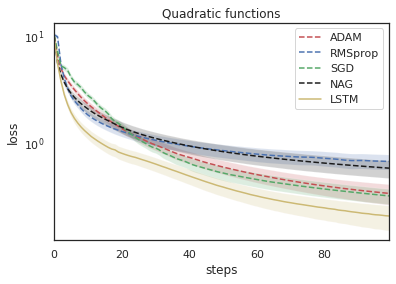

In [12]:
ax = sns.tsplot(data=fit_data[:,:,:], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Quadratic functions')
plt.show()

## MNIST

Now we move on to MNIST. Because all the rest of our code is implemented, we just need to implement the network specified in the paper, namely a single hidden layer, sigmoid, 20 hidden units network. We make it easy to change sigmoid to some other activation, add layers, and change the number of units, because all of these are attempted in the paper.

In [23]:
class MNISTLoss:
    def __init__(self, training=True):
        dataset = datasets.MNIST(
            'mnist', train=True, download=True,
            transform=torchvision.transforms.ToTensor()
        )
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices),
            num_workers=10
        )

        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class MNISTNet(MetaModule):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()

        inp_size = 28*28
        self.layers = {}
        for i in range(n_layers):
            self.layers[f'mat_{i}'] = MetaLinear(inp_size, layer_size)
            inp_size = layer_size

        self.layers['final_mat'] = MetaLinear(inp_size, 10)
        self.layers = ModuleDict(self.layers)

        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()
    
    #Added method to resolve the problem of parameters empty 
    def all_named_parameters(self):
        return [(k, v) for k, v in self.named_parameters()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))
        cur_layer = 0
        while f'mat_{cur_layer}' in self.layers:
            inp = self.activation(self.layers[f'mat_{cur_layer}'](inp))
            cur_layer += 1

        inp = F.log_softmax(self.layers['final_mat'](inp), dim=1)
        l = self.loss(inp, out)
        return l

Like before, we find a promising learning rate (0.001) using a small number of epochs (10) and optimize it fully using more epochs (50).

In [ ]:
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(MNISTLoss, MNISTNet, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10)[0])

In [24]:
loss, mnist_optimizer = fit_optimizer(MNISTLoss, MNISTNet, lr=0.01, n_epochs=5, n_tests=20, out_mul=0.1, preproc=True)
print(loss)

/tmp/ipykernel_37828/1148724508.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(n_epochs), 'epochs'):


epochs:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_37828/1148724508.py:104: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(20), 'iterations'):


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_37828/1148724508.py:109: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(n_tests), 'tests')


tests:   0%|          | 0/20 [00:00<?, ?it/s]

67.04167
100000000000000000 67.04167


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

66.639015
67.04167 66.639015


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

59.665016
66.639015 59.665016


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

60.164417


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

tests:   0%|          | 0/20 [00:00<?, ?it/s]

58.729317
59.665016 58.729317
58.729317


We find the best learning rates for the competitors...

In [25]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet, opt, **kwargs, n_tests=10))
    

/tmp/ipykernel_37828/2027723200.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

/tmp/ipykernel_37828/2027723200.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_tests), 'tests'):


tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

64.57146


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

69.138756


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

65.722664


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

58.37201


And plot! for context, the graph in the original paper looks like this:

![image.png](attachment:image.png)

Again we get similar results!!!

In [29]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]

N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

/tmp/ipykernel_37828/2027723200.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_tests), 'tests'):


tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

tests:   0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(Optimizer(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet, 1, 200, 200, out_mul=0.1, should_train=False))

/home/student1/miniconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


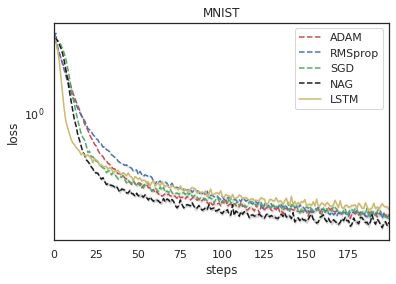

In [32]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST')
plt.show()

In [ ]:
class MNISTNet2Layer(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(n_layers=2, *args, **kwargs)
        
class MNISTNetBig(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(layer_size=40, *args, **kwargs)
        
class MNISTRelu(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = nn.ReLU()

In [ ]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet2Layer, opt, **kwargs, n_tests=10))
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNetBig, opt, **kwargs, n_tests=10))
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTRelu, opt, **kwargs, n_tests=10))


Same as above, for a 2 layer network. Again LSTM does great even though it was trained on a single layer network, and again we are similar to the paper:

![image.png](attachment:image.png)

In [ ]:
QUAD_LRS = [0.01, 0.003, 0.03, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet2Layer, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet2Layer, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (2 layers)')
plt.show()

Same as above but for a single layer, 40 hidden unit network.

Paper comparison:
![image.png](attachment:image.png)

In [ ]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]

N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNetBig, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNetBig, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (40 hidden units)')
plt.show()

Finally, same as above but with ReLU. As we shall see, the optimizer doesn't generalize very well to a different activation function, and so the other optimizers do much better. My reproduction shows this too although strangely my optimizer seems to do better than the one from the paper.

Original:
![image.png](attachment:image.png)

In [ ]:
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
N_TESTS = 100


fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTRelu, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTRelu, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.show()

# CIFAR1O 
As it was in the paper we decided to test CIFAR10 datasets

In [ ]:
class CIFAR10Loss:
    def __init__(self, training=True):
        resize = torchvision.transforms.Resize(28)
        to_tensor = torchvision.transforms.ToTensor()
        gray_scale = torchvision.transforms.Grayscale()
        dataset = datasets.CIFAR10(
            'cifar10', train=True, download=True,
            transform=torchvision.transforms.Compose([resize,gray_scale,to_tensor]) 
        )
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))

        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class CIFAR10Net(MetaModule):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()

        inp_size = 28*28
        self.layers = {}
        for i in range(n_layers):
            self.layers[f'mat_{i}'] = MetaLinear(inp_size, layer_size)
            inp_size = layer_size

        self.layers['final_mat'] = MetaLinear(inp_size, 10)
        self.layers = ModuleDict(self.layers)

        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.named_parameters()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))

        cur_layer = 0
        while f'mat_{cur_layer}' in self.layers:
            inp = self.activation(self.layers[f'mat_{cur_layer}'](inp))
            cur_layer += 1

        inp = F.log_softmax(self.layers['final_mat'](inp), dim=1)
        l = self.loss(inp, out)
        return l

In [ ]:
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(CIFAR10Loss, CIFAR10Net, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10)[0])

In [ ]:
loss, cifar_10_optimizer = fit_optimizer(CIFAR10Loss, CIFAR10Net, lr=0.01, n_epochs=5, n_tests=20, out_mul=0.1, preproc=True)
print(loss)

In [ ]:
#Competitor's loss rate 
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(CIFAR10Loss, CIFAR10Net, opt, **kwargs, n_tests=10))

In [ ]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]

N_TESTS = 100

fit_data_CIFAR10 = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data_CIFAR10[:, :, i] = np.array(fit_normal(CIFAR10Loss, CIFAR10Net, opt, lr=lr, n_tests=N_TESTS, n_epochs=20, **extra_kwargs))

In [ ]:
@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(Optimizer(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data_CIFAR10[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, cifar_10_optimizer, None, CIFAR10Loss, CIFAR10Net, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data_CIFAR10[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('CIFAR10 RELU')
plt.show()

# CIFAR100 
Here we used the dataset cifar100

In [33]:
class CIFAR100Loss:
    def __init__(self, training=True):
        resize = torchvision.transforms.Resize(28) # This won't do anything, since images are already at that size
        to_tensor = torchvision.transforms.ToTensor()
        gray_scale = torchvision.transforms.Grayscale()
        dataset = datasets.CIFAR100(
            'cifar100', train=True, download=True,
            transform=torchvision.transforms.Compose([resize,gray_scale,to_tensor]) 
        )
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices),
            num_workers=10
        )

        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class CIFAR100Net(MetaModule):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()

        inp_size = 28*28
        self.layers = {}
        for i in range(n_layers):
            self.layers[f'mat_{i}'] = MetaLinear(inp_size, layer_size)
            inp_size = layer_size

        self.layers['final_mat'] = MetaLinear(inp_size, 100)
        self.layers = ModuleDict(self.layers)

        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.named_parameters()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))
        cur_layer = 0
        while f'mat_{cur_layer}' in self.layers:
            inp = self.activation(self.layers[f'mat_{cur_layer}'](inp))
            cur_layer += 1

        inp = F.log_softmax(self.layers['final_mat'](inp), dim=1)
        l = self.loss(inp, out)
        return l

In [34]:
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(CIFAR100Loss, CIFAR100Net, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10)[0])
    

/tmp/ipykernel_37828/3858861362.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):


all:   0%|          | 0/11 [00:00<?, ?it/s]

Trying lr: 0.003


/tmp/ipykernel_37828/1148724508.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(n_epochs), 'epochs'):


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_37828/1148724508.py:104: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(20), 'iterations'):


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_37828/1148724508.py:109: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(n_tests), 'tests')


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.1836
100000000000000000 461.1836


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.96143
461.1836 460.96143


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.9074
460.96143 460.9074


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.84634
460.9074 460.84634


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.85147


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.7876
460.84634 460.7876


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.88776


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.80737


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.91302


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.8454
460.7876
Trying lr: 0.001


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
463.3773
100000000000000000 463.3773


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
462.87582
463.3773 462.87582


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.1819
462.87582 461.1819


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.89423
461.1819 460.89423


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.91943


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.91562


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.87637
460.89423 460.87637


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.8603
460.87637 460.8603


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.90976


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.77295
460.8603 460.77295
460.77295
Trying lr: 0.0003


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.4406
100000000000000000 461.4406


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.32764
461.4406 461.32764


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.47934


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.44855


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.38144


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.36978


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.4711


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.1649
461.32764 461.1649


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.11572
461.1649 461.11572


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.02765
461.11572 461.02765
461.02765
Trying lr: 0.0001


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.30322
100000000000000000 461.30322


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.3037


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.28027
461.30322 461.28027


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.19003
461.28027 461.19003


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.2514


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.22968


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.12433
461.19003 461.12433


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.17447


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.04745
461.12433 461.04745


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.19864
461.04745
Trying lr: 3e-05


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
470.84235
100000000000000000 470.84235


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
467.21576
470.84235 467.21576


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
465.83878
467.21576 465.83878


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
465.99945


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
464.9857
465.83878 464.9857


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
464.40054
464.9857 464.40054


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
464.57648


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
464.7824


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
464.70245


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
464.4064
464.40054
Trying lr: 1e-05


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
503.61386
100000000000000000 503.61386


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.60156
503.61386 461.60156


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.5936
461.60156 461.5936


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.55826
461.5936 461.55826


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.47528
461.55826 461.47528


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.53238


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.45636
461.47528 461.45636


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.47223


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.4615


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.43286
461.45636 461.43286
461.43286
Trying lr: 0.01


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.3813
100000000000000000 461.3813


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.011
461.3813 461.011


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.84082
461.011 460.84082


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.79932
460.84082 460.79932


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.7408
460.79932 460.7408


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.75473


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.8011


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.7736


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.78336


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.7104
460.7408 460.7104
460.7104
Trying lr: 0.03


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.9786
100000000000000000 460.9786


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.79132
460.9786 460.79132


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.8266


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.73227
460.79132 460.73227


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.79175


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.64313
460.73227 460.64313


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.69296


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.61432
460.64313 460.61432


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.6337


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.66815
460.61432
Trying lr: 0.1


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.39178
100000000000000000 461.39178


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.32162
461.39178 461.32162


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.20908
461.32162 461.20908


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.86578
461.20908 460.86578


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.93277


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.70743
460.86578 460.70743


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.74252


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.66373
460.70743 460.66373


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.72565


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.80844
460.66373
Trying lr: 0.3


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.1819
100000000000000000 461.1819


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.3851


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.29803


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.95786
461.1819 460.95786


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.89413
460.95786 460.89413


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.92032


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.83438
460.89413 460.83438


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.877


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.79224
460.83438 460.79224


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.8714
460.79224
Trying lr: 1.0


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.43134
100000000000000000 461.43134


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.403
461.43134 461.403


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.39072
461.403 461.39072


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.3977


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.37128
461.39072 461.37128


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.35345
461.37128 461.35345


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.3973


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.49658


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.3873


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/5 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.42862
461.35345


In [35]:
loss, cifar_optimizer = fit_optimizer(CIFAR100Loss, CIFAR100Net, lr=0.01, n_epochs=5, n_tests=20, out_mul=0.1, preproc=True)
print(loss)

/tmp/ipykernel_37828/1148724508.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(n_epochs), 'epochs'):


epochs:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_37828/1148724508.py:104: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(20), 'iterations'):


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_37828/1148724508.py:109: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(n_tests), 'tests')


tests:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.22208
100000000000000000 461.22208


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.41388


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.96176
461.22208 460.96176


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.79315
460.96176 460.79315


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/20 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.8296
460.79315


In [36]:
#Competitor's loss rate 
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(CIFAR100Loss, CIFAR100Net, opt, **kwargs, n_tests=10))

/tmp/ipykernel_37828/2027723200.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

/tmp/ipykernel_37828/2027723200.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_tests), 'tests'):


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.18048


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
459.70108


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
459.70428


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
458.2339


In [37]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100
fit_data_CIFAR = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data_CIFAR[:, :, i] = np.array(fit_normal(CIFAR100Loss, CIFAR100Net, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

/tmp/ipykernel_37828/2027723200.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_tests), 'tests'):


tests:   0%|          | 0/100 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

tests:   0%|          | 0/100 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

tests:   0%|          | 0/100 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

tests:   0%|          | 0/100 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

In [38]:
@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(Optimizer(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data_CIFAR[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, cifar_optimizer, None, CIFAR100Loss, CIFAR100Net, 1, 200, 200, out_mul=0.1, should_train=False))

/tmp/ipykernel_37828/3431566102.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]


optimizer:   0%|          | 0/100 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

/home/student1/miniconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


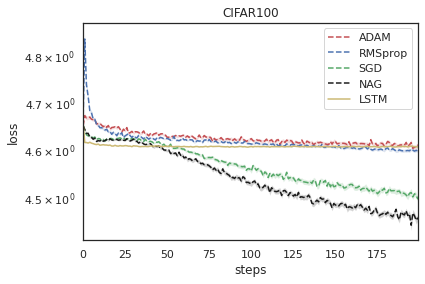

In [39]:
ax = sns.tsplot(data=fit_data_CIFAR[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('CIFAR100')
plt.show()

Test Another activation function RELU with CIFAR100



In [40]:
class CIFAR100Relu(CIFAR100Net):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = nn.ReLU()

In [41]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(CIFAR100Loss, CIFAR100Relu, opt, **kwargs, n_tests=10))

/tmp/ipykernel_37828/2027723200.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

/tmp/ipykernel_37828/2027723200.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_tests), 'tests'):


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.98032


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
461.15216


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
460.56573


Learning rates:   0%|          | 0/11 [00:00<?, ?it/s]

tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


tests:   0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
459.8343


In [42]:
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
N_TESTS = 100


fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data_CIFAR[:, :, i] = np.array(fit_normal(CIFAR100Loss, CIFAR100Relu, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data_CIFAR[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, cifar_optimizer, None, CIFAR100Loss, CIFAR100Relu, 1, 200, 200, out_mul=0.1, should_train=False))

/tmp/ipykernel_37828/2027723200.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(n_tests), 'tests'):


tests:   0%|          | 0/100 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

tests:   0%|          | 0/100 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

tests:   0%|          | 0/100 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

tests:   0%|          | 0/100 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

/tmp/ipykernel_37828/3431566102.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]


optimizer:   0%|          | 0/100 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

/home/student1/miniconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


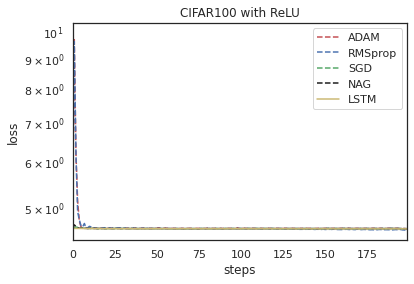

In [43]:
ax = sns.tsplot(data=fit_data_CIFAR[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('CIFAR100 with ReLU')
plt.show()